In [1]:
import sys
sys.path.append('../src')

from base_sindy import K_Poly_Spline
import matplotlib.pyplot as plt
import numpy as np

/Users/terrycox/UofUCode/NumericalAnaylsisI/numerical_analysis_1/final_project/src/base_sindy.py


In [2]:
x = [0,1,2,3,4]
y = [21,24,24,18,16]

x = np.linspace(0,10, 100)


x = np.linspace(0,12.5, 50)
c0 = 1
c1 = 1
k = 0.25
y = c0*np.cos(np.sqrt(k)*x)+c1*np.sin(np.sqrt(k)*x)

cubic_spline = K_Poly_Spline(x,y, k=5, method='GEM')

4
3
		built A and b. SIZE: (294, 294)


In [3]:
len(cubic_spline.f)

49

In [4]:


#calculate determinant of matrix
np.linalg.det(cubic_spline.A)



1.492098345334234e+63

In [5]:
from scipy.interpolate import UnivariateSpline
def smooth(t, x, coef=0.5):
    spl = UnivariateSpline(t, x)
    spl.set_smoothing_factor(coef)
    #print('smoothing:', coef)
    return t, spl(t)

In [6]:
#%%timeit
x_s = np.linspace(x[0], x[-1], 100)
y_s = cubic_spline.interpolate(x_s, 0)

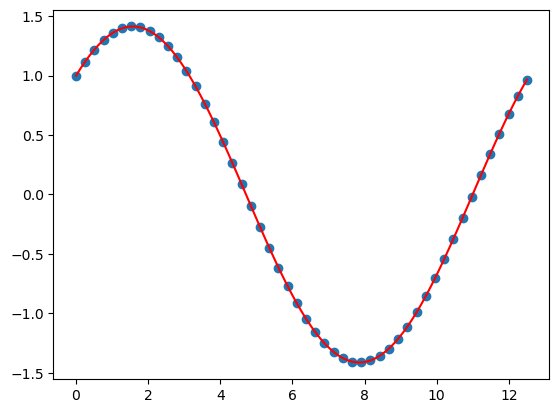

In [7]:
plt.plot(x, y, 'o')
plt.plot(x_s, y_s, 'r')
plt.show()

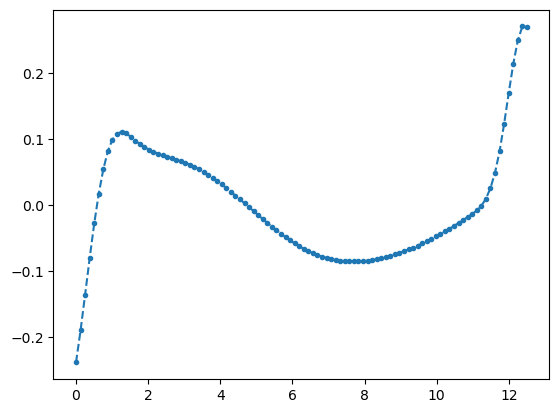

In [10]:
d = 4

dy = cubic_spline.interpolate(x_s, d)#np.diff(y_s)/np.diff(x_s)
_, dy = smooth(x_s, dy, coef=0.9)

plt.plot(x_s, dy, '.--')
plt.show()

In [11]:
from sklearn.linear_model import Ridge, Lasso

In [12]:
basis = []
label = []
for d in range(1,5):
    dx = cubic_spline.interpolate(x_s, d)
    _, dx = smooth(x_s, dx, coef=1)
    for p in range(1,5):
        basis.append(dx**p)
        label.append(f'dx_{d}^{p}')
basis = np.array(basis)
     

In [13]:
coefs = Ridge(1).fit(basis.T, cubic_spline.interpolate(x_s, 0)).coef_
list(zip(label, coefs))

[('dx_1^1', 0.04862614723808705),
 ('dx_1^2', 0.34427766407878607),
 ('dx_1^3', -0.16533146755115408),
 ('dx_1^4', 0.07785814209191141),
 ('dx_2^1', -3.2028411299973767),
 ('dx_2^2', 0.03091368693455067),
 ('dx_2^3', -0.25020109430537635),
 ('dx_2^4', 0.0016841414415141472),
 ('dx_3^1', 0.10537712068435871),
 ('dx_3^2', 0.041231130125684655),
 ('dx_3^3', 0.0038362645404957517),
 ('dx_3^4', 0.0009632588368320243),
 ('dx_4^1', 0.6539273716008801),
 ('dx_4^2', -0.08374745298628303),
 ('dx_4^3', -0.020142707733690902),
 ('dx_4^4', -0.007109760990891677)]

In [14]:
from base_sindy import GEM
import time
def ridge_gem(basis, b, alpha = 1):
    #b = cubic_spline.interpolate(x_s, 0)
    basis = np.asmatrix(basis)
    

    A = np.matmul(basis.T,basis)
    I = np.identity(A.shape[0])
    start = time.time()
    x = GEM((A+alpha*I), np.matmul(basis.T,b).T)
    end = time.time()
    return x

def STLS(basis, b, labels, iterates=5, alpha = 1):
    
    for i in range(iterates):
        x = ridge_gem(basis.T, b, alpha)
        labs = []
        basis_new = []
        counter = 0
        perc = np.abs(x)/np.sum(np.abs(x))
        for l, x_i in zip(labels, x):
            if np.abs(x_i) > 0.0001 and perc[counter] > 0.05:
                labs.append(l)
                basis_new.append(basis[counter])
            counter +=1
        basis = np.array(basis_new)
        labels = np.array(labs)
    return x, labels

c, l = STLS(basis, cubic_spline.interpolate(x_s, 0), label)

In [15]:
list(zip(l, c))

[('dx_2^1', -3.2877236332397777), ('dx_4^1', 0.6701164079002163)]

In [16]:
list(zip(l,np.abs(c)/np.sum(np.abs(c))))

[('dx_2^1', 0.8306863337237854), ('dx_4^1', 0.16931366627621458)]

In [17]:
def sindy(x, y, alpha = 1):
    cubic_spline = K_Poly_Spline(x,y, k=5, method='GEM')
    x_s = np.linspace(x[0], x[-1], 100)
    basis = []
    label = []
    for d in range(1,4):
        dx = cubic_spline.interpolate(x_s, d)
        _, dx = smooth(x_s, dx, coef=1)
        for p in range(1,5):
            basis.append(dx**p)
            label.append(f'dx_{d}^{p}')
    basis = np.array(basis)
    
    c, l = STLS(basis, cubic_spline.interpolate(x_s, 0), label, 5, alpha)
    return list(zip(l, c))

def least_sqr(x, y):
    cubic_spline = K_Poly_Spline(x,y, k=5, method='GEM')
    x_s = np.linspace(x[0], x[-1], 100)
    basis = [cubic_spline.interpolate(x_s, 2)]
    label = ['dxx']
    basis = np.array(basis)
    
    c, l = STLS(basis, cubic_spline.interpolate(x_s, 0), label, 1, alpha=0)
    return list(zip(l, c))

In [18]:
import random
def esindy(n_models, ratio_pts, x, y, alpha = 1, model='sindy'):
    coefs = {}
    for m in range(n_models):
        print('model:', m)
        sample = random.sample(list(range(len(x))), int(len(x)*(ratio_pts)))
        sample.sort()
        if model == 'sindy':
            cs = sindy(x[sample], y[sample], alpha)
        else:
            cs = least_sqr(x[sample], y[sample])
        for c in cs:
            if c[0] in coefs.keys():
                coefs[c[0]].append(c[1])
            else:
                coefs[c[0]] = [c[1]]
    return coefs
        

In [19]:
x = np.linspace(0,12.5, 200)
c0 = 1
c1 = 1
k = 0.25
y = c0*np.cos(np.sqrt(k)*x)+c1*np.sin(np.sqrt(k)*x)

In [20]:
n_models = 50
ratio_pts = 0.25

coefs = esindy(n_models, ratio_pts, x, y, alpha = 0, model='least_sqr')

model: 0
4
3
		built A and b. SIZE: (294, 294)


KeyboardInterrupt: 

In [59]:
coefs['dxx']

[-2.4044197957619913,
 -2.64509816432709,
 -4.000793628936576,
 0.30121473538576715,
 -3.4266417123584403,
 -3.826271660294531,
 -3.532611714389462,
 -1.8970744734540437,
 -0.5504857352435921,
 -3.32797000880718,
 -1.3053564563735394,
 -1.7421151642403743,
 -3.9680898239265803,
 -3.982768781854608,
 -0.4466149872486501,
 -3.788720891691038,
 -2.40731131566748,
 -3.4637206769937876,
 -2.8660295734528907,
 -0.21297152919330697,
 -1.582407215294257,
 -3.975267855888249,
 -3.2329825009894995,
 -2.4450871444653446,
 -0.0019479910108064341,
 -0.7164544943434898,
 -3.492327379731331,
 -0.8746547040086406,
 -2.6508464914026657,
 -2.8068225562819675,
 -0.11575024372987826,
 -2.133467241844862,
 -2.8669049859493736,
 -0.682792487719002,
 -4.063506772337109,
 -0.6218800911404493,
 -2.1321531027955203,
 -2.268523054846978,
 -3.932272949997245,
 -3.8966480712781593,
 -1.6060246536734593,
 -3.896482084065008,
 -0.6356501238996833,
 -3.7247420436420855,
 -4.0130563285776395,
 -3.9731857102402985,
 -0

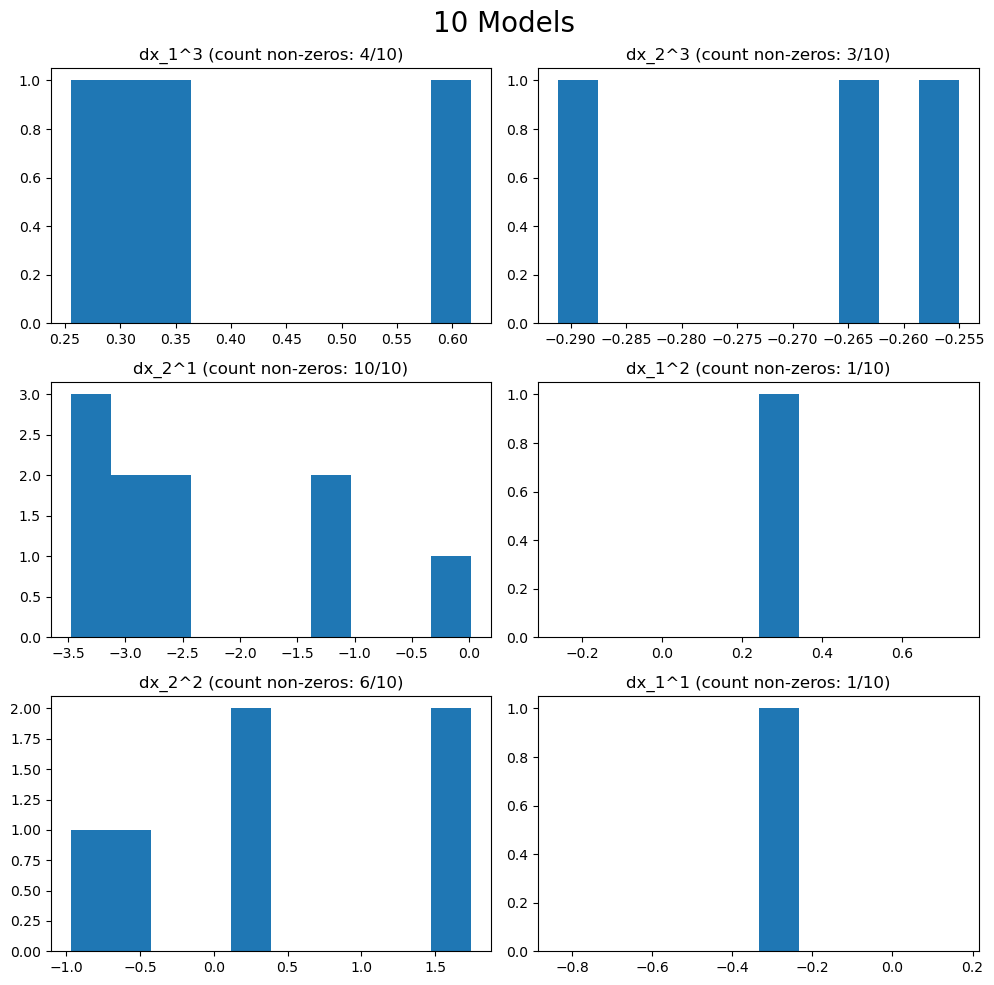

In [34]:
coef_ls = list(coefs.keys())
fig, axs = plt.subplots(3,2, figsize=(10,10))
fig.suptitle('10 Models', size=20)
counter = 0
for c1, c2 in zip(coef_ls[0:3], coef_ls[3:]):
    axs[counter, 0].hist(coefs[c1])
    axs[counter, 0].set_title(f'{c1} (count non-zeros: {len(coefs[c1])}/{10})')
    
    axs[counter, 1].hist(coefs[c2])
    axs[counter, 1].set_title(f'{c2} (count non-zeros: {len(coefs[c2])}/{10})')
    counter +=1
fig.tight_layout()
plt.savefig('./images/10models.png')
plt.show()

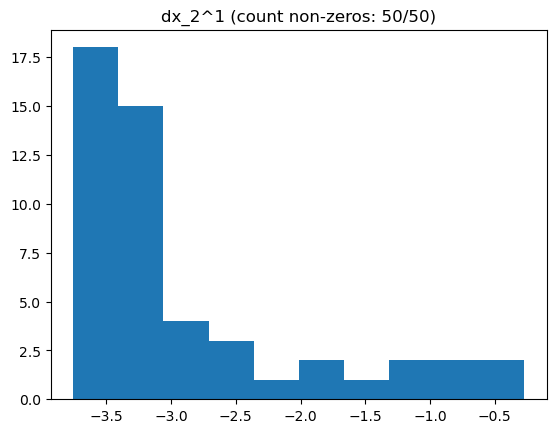

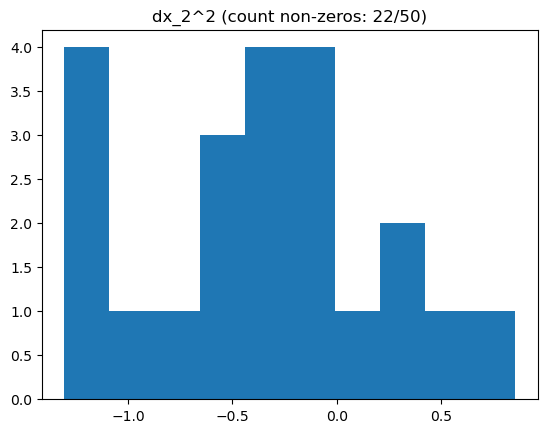

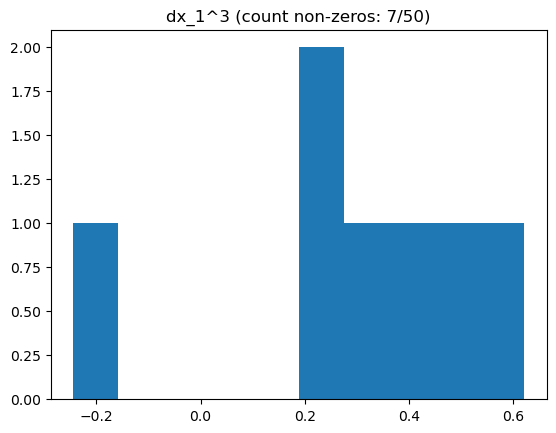

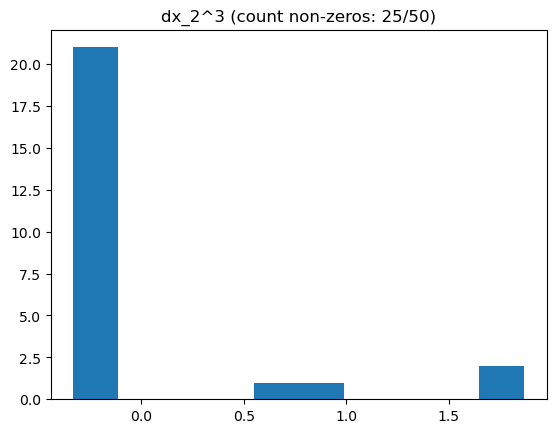

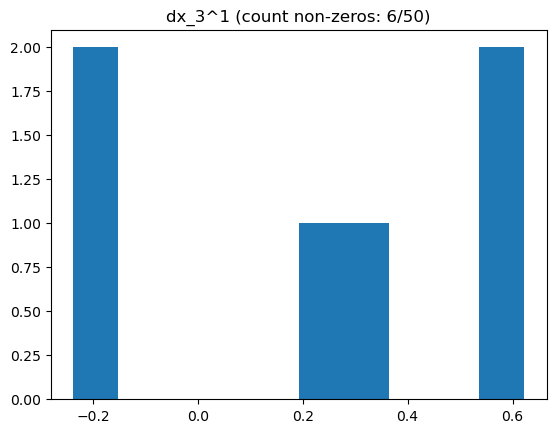

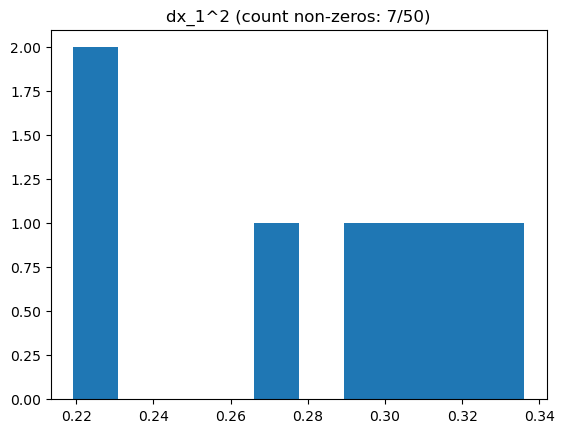

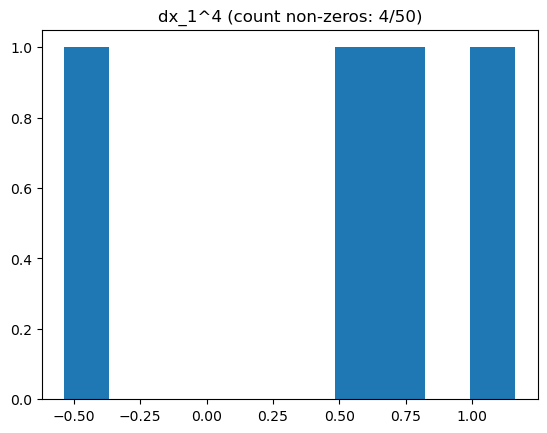

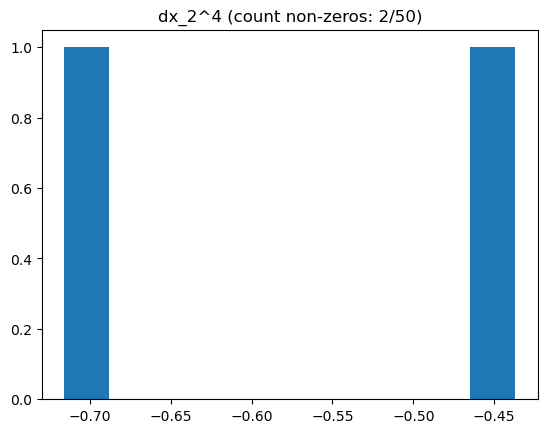

In [20]:
for k, v in coefs.items():
    plt.hist(v)
    plt.title(f'{k} (count non-zeros: {len(v)}/{n_models})')
    plt.show()

In [74]:
def upper_triangular(M):
    # move all zeros to buttom of matrix
    M = np.concatenate((M[np.any(M != 0, axis=1)], M[np.all(M == 0, axis=1)]), axis=0)

    # iterate over matrix rows
    for i in range(0, M.shape[0]):

        # initialize row-swap iterator
        j = 1

        # select pivot value
        pivot = M[i][i]

        # find next non-zero leading coefficient
        while pivot == 0 and i + j < M.shape[0]:
            # perform row swap operation
            M[[i, i + j]] = M[[i + j, i]]

            # incrememnt row-swap iterator
            j += 1

            # get new pivot
            pivot = M[i][i]

        # if pivot is zero, remaining rows are all zeros
        if pivot == 0:
            # return upper triangular matrix
            return M

        # extract row
        row = M[i]

        # get 1 along the diagonal
        M[i] = row / pivot

        # iterate over remaining rows
        for j in range(i + 1, M.shape[0]):
            # subtract current row from remaining rows
            M[j] = M[j] - M[i] * M[j][i]

    # return upper triangular matrix
    return M
def back_substitute(A,b):
    n = len(b)
    x = np.zeros(n)

    for i in range(n-1, -1, -1):
        temp = b[i]
        for j in range(n-1, i, -1):
            temp -= x[j]*A[i,j]

        x[i] = temp/A[i,i]
    return x

In [78]:
back_substitute(upper_triangular(c), cubic_spline.b)

AxisError: axis 1 is out of bounds for array of dimension 0

In [76]:
import sympy
sympy.Matrix(upper_triangular(cubic_spline.A))

Matrix([
[1.0, 1.0, 1.0,   0,   0,   0,    0,    0,                 0,     0,                 0,                 0],
[  0, 1.0, 2.0, 2.0, 1.0,   0,    0,    0,                 0,     0,                 0,                 0],
[  0,   0, 1.0,   0,   0,   0,    0,    0,                 0,     0,                 0,                 0],
[  0,   0,   0, 1.0, 1.0, 1.0,    0,    0,                 0,     0,                 0,                 0],
[  0,   0,   0,   0, 1.0, 1.5,    0,    0,                 0,     0,                 0,                 0],
[  0,   0,   0,   0,   0, 1.0, -8.0, -2.0,                 0,     0,                 0,                 0],
[  0,   0,   0,   0,   0,   0,  1.0,  0.5,              0.25,     0,                 0,                 0],
[  0,   0,   0,   0,   0,   0,    0,  1.0, 0.833333333333333,     0,                 0,                 0],
[  0,   0,   0,   0,   0,   0,    0,    0,               1.0, -36.0,              -6.0,                 0],
[  0,   0,   0,   0

In [77]:
c = []
for a, b in zip(cubic_spline.A, cubic_spline.b):
    c.append(list(a)+[b])

In [5]:
np.matmul(cubic_spline.A.T, cubic_spline.A)

array([[ 4.600e+01,  1.900e+01,  4.000e+00,  1.000e+00, -4.500e+01,
        -1.800e+01, -3.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00],
       [ 1.900e+01,  1.300e+01,  3.000e+00,  1.000e+00, -1.800e+01,
        -8.000e+00, -2.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00],
       [ 4.000e+00,  3.000e+00,  2.000e+00,  1.000e+00, -3.000e+00,
        -2.000e+00, -1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00],
       [ 1.000e+00,  1.000e+00,  1.000e+00,  2.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00],
       [-4.500e+01, -1.800e+01, -3.000e+00,  0.000e+00,  3.980e+02,
         1.230e+02,  3.200e+01, 

In [8]:
np.matmul(np.linalg.inv(np.matmul(cubic_spline.A.T, cubic_spline.A)), np.matmul(cubic_spline.A.T, cubic_spline.b))

array([-3.03571429e-01,  1.79176229e-10,  3.30357143e+00,  2.10000000e+01,
       -1.48214286e+00,  3.53571429e+00, -2.32142849e-01,  2.21785714e+01,
        3.23214286e+00, -2.47500000e+01,  5.63392857e+01, -1.55357143e+01,
       -1.44642857e+00,  1.73571429e+01, -6.99821429e+01,  1.10785714e+02])

In [16]:
import sympy
def rref(A, b):
    A = np.matmul(A.T, A)
    b = np.matmul(A.T, b)
    #print(A, b)
    c = []
    for a, b in zip(A, b):
        c.append(list(a)+[b])
    m, i = sympy.Matrix(c).rref()
    return m, i


In [17]:
rref(cubic_spline.A, cubic_spline.b)

(Matrix([
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,      21.0000000000026],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,      23.9999999999999],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,      23.9999999999954],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,      24.0000000000011],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,      23.9999999999945],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,      18.0000000000243],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,      17.9999999999697],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,      16.0000000000095],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,  4.50981302043499e-12],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -3.57857107780587e-11],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,  9.06933272920638e-11],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, -7.30479260303795e-11],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1.59249931717581e-12],
 [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [20]:

from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations

In [21]:
# Simple loop
for i in range(100):
    pass

# Loop with a progress bar
for i in trange(100):
    time.sleep(0.01)

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
for i in tqdm(range(100)):
    time.sleep(0.01)

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:

p_bar = tqdm(range(10))
for number in p_bar:
    time.sleep(0.5)
    p_bar.set_description(f'Working on "{number}"')

  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
from tqdm.notebook import tqdm
# or from tqdm import tqdm

for i in tqdm(range(10)):
    time.sleep(0.5)

  0%|          | 0/10 [00:00<?, ?it/s]